In [ ]:
# load the packages
library(tidyverse)
library(lubridate)
library(curl)

In [ ]:
# Get the time series data from Johns Hopkins University
ts_data <- read_csv("https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")

In [ ]:
# preprocess the data so that
# remove province/state information, lat long information, then
# rename country/region to something more readable
# convert the wide data to long format then
# convert date from character to date-time format, then
# filter to keep only those data where they had 100 or more cases (minimum 100 cases) then
# take out China to keep all non-chinese countries

ts_100_non_china <- ts_data %>%
 select(-"Province/State", -Lat, -Long) %>%
 rename(country_region = "Country/Region") %>%
 gather(date, count, -country_region) %>%
 mutate(dated = mdy(date)) %>%
 filter(count >= 100) %>%
 filter(country_region != "China")
 
 ## Now create a small data set to find out country-wise first date when 100 cases reached
ts_start <- ts_100_non_china %>% 
  group_by(country_region) %>%
  summarise(first_date = min(dated))

## Now merge the two data sets then

ts_100 <- inner_join(ts_100_non_china, ts_start)

## Now create a seprate variable of days since 100 cases

ts_100_final <- ts_100 %>% 
  mutate(days_since_100 = as.numeric(days(dated - first_date)),
        number_of_days = round(days_since_100 / 86400, 0)
        )

# Save ts_100_final to csv
write_csv(ts_100_final, "ts_100_final.csv")

In [22]:
## Now create a small subset of the countries we are interested in from the ts_100_final
## call it select_countries


select_countries <- ts_100_final %>%
  filter(country_region %in% c("US", "Italy", "Japan", "Spain", "Korea, South",
         "Singapore", "Taiwan", "India", "Germany", "New Zealand"))



Saving 6.67 x 6.67 in image


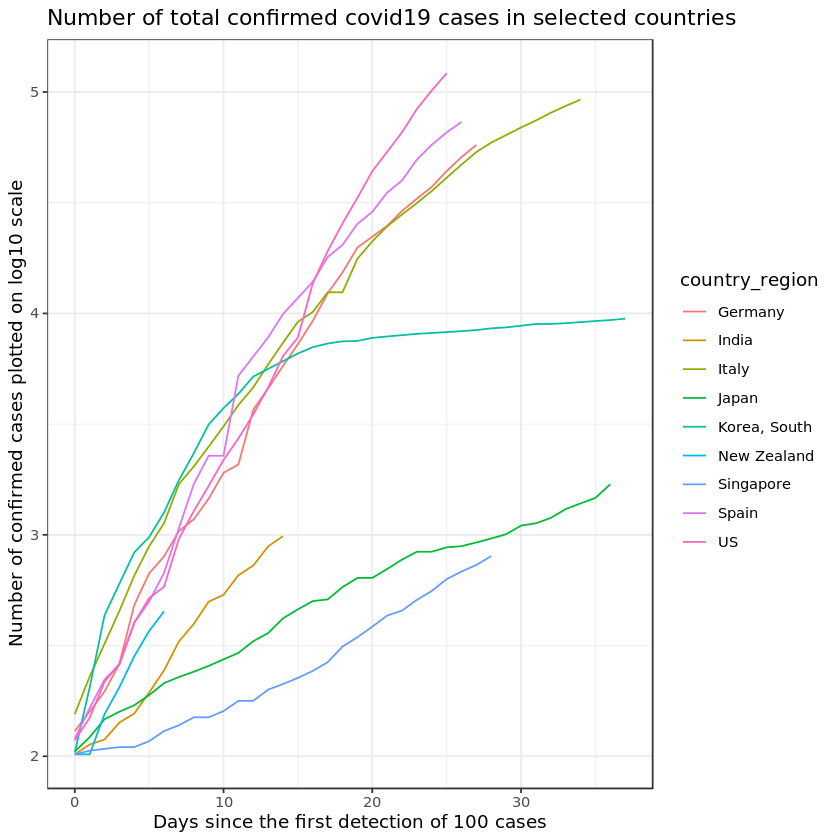

In [23]:
## Plot number of days on X axis and log(count, base = 10) on y axis

select_countries %>%
 ggplot(aes(x = number_of_days)) +
 geom_line(aes(y = log(count, base = 10), colour = country_region)) +
 theme_bw() + 
 ggtitle("Number of total confirmed covid19 cases in selected countries") +
 xlab("Days since the first detection of 100 cases") +
 ylab("Number of confirmed cases plotted on log10 scale") +
 ggsave("cases_since_100_nz.jpg")

In [ ]:
## for death plotting, let's take data from ourworlddata.org and see
## get the data first
total_deaths <- read_csv("https://covid.ourworldindata.org/data/ecdc/total_deaths.csv")

In [25]:
## Select the countries we are interested then
## rename South Korea to Korea

countries <- total_deaths %>%
  select(date, World, `United States`, Italy, China, Japan, Spain, Algeria, `South Korea`, 
         Singapore, Taiwan, France, India, Germany, Canada, Australia) %>%
  rename(US = `United States`,
        Korea = `South Korea`)



In [28]:
## Find out when first death occurred
when_first_death <- countries %>%
  filter(World == 1 ) %>%
  summarise(when_first_death = min(date))
when_first_death ## returns 2020-01-11
# we will deduct this date from the rest to find the number of days

when_first_death
<date>
2020-01-11


In [36]:
## create a separate data set of days_since_first_death
## create a new variable days_since then
## convert it from wide to long format for analyses
# the time zone is GMT as that is when ecdc update their data set

days_since_data <- countries %>%
 mutate(days_since = as.numeric(date - when_first_death$when_first_death)) %>%
 gather(countries, count, -date, -days_since)

## select only a few countries among the list

some_countries <- days_since_data %>%
  filter(countries %in% c("US", "Italy", "China", "Japan", "Spain", "France", "Korea", "India", "Canada",
                         "Germany", "Australia")) 

Saving 6.67 x 6.67 in image


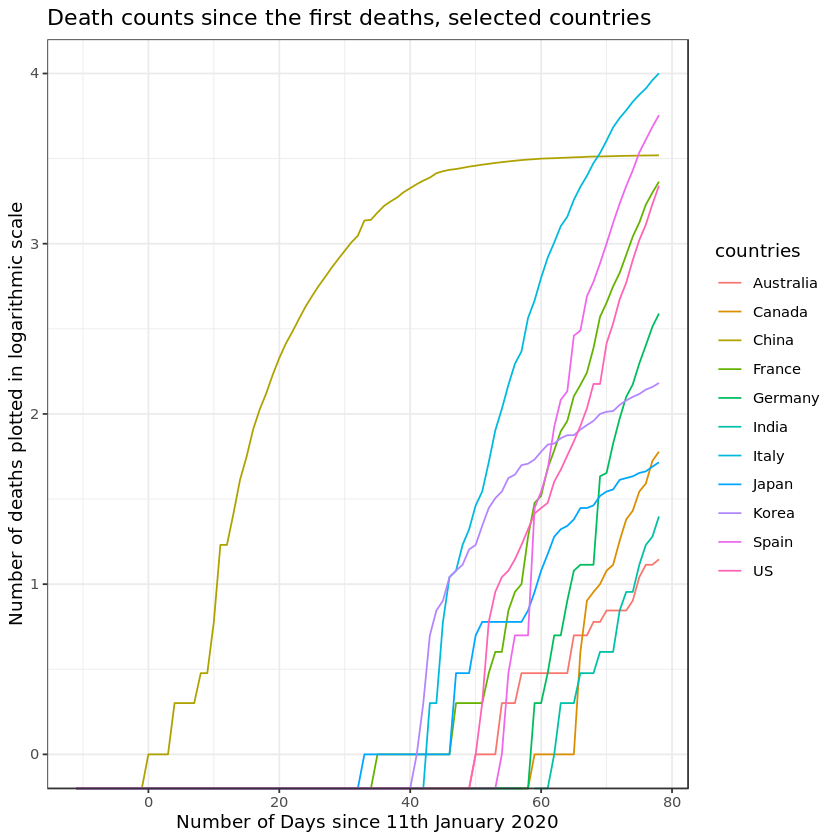

In [37]:
## Now plot the death counts

ggplot(some_countries, aes(x = days_since)) +
  geom_line(aes(y = log(count, base = 10), colour = countries)) +
  ggtitle("Death counts since the first deaths, selected countries") +
  xlab("Number of Days since 11th January 2020") +
  ylab("Number of deaths plotted in logarithmic scale") +
  theme_bw() +
  ggsave("deaths_since_1_death.jpg")